### Synopsis
This code plots the averaged SA-XPCS results for the temperature ramping (up and down).   
Need to run the analysis code to generate the `checkpoint.pickle` file prior to running the figure rendering code

In [1]:

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle
import matplotlib.ticker as ticker


Minimum chi-squared: Curve 1, q_scale=1.0500, i_scale=0.8900, chi2=0.0001


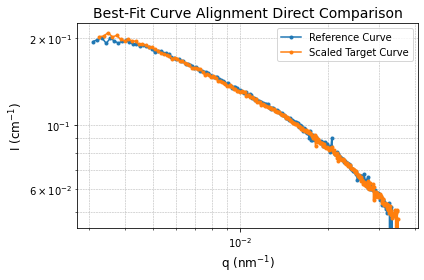

In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

# Load the data
with open('checkpoint.pickle', 'rb') as f:
    avg_ramp_up = pickle.load(f)
    avg_ramp_down = pickle.load(f)
    t_el = pickle.load(f)
    ql_sta = pickle.load(f)
    ql_dyn = pickle.load(f)
    
# Define the chi-squared metric for direct comparison
def chi_squared_direct(q_scale, i_scale, ref_x, ref_y, target_x, target_y):
    """
    Calculate chi-squared directly comparing the reference curve with the scaled target curve.
    Formula: chi^2 = sum((O - E)^2 / E)
    """
    # Scale the target curve
    target_x = np.log10(target_x[:-20])
    target_y = np.log10(target_y[:-20])
    ref_x = np.log10(ref_x[:-20])
    ref_y= np.log10(ref_y[:-20])

    scaled_x = target_x + np.log10(q_scale)
    scaled_y = target_y + np.log10(i_scale)
       
    range_x_min = np.max([np.min(scaled_x), np.min(ref_x)])
    range_x_max = np.min([np.max(scaled_x), np.max(ref_x)])
    range_x_overlap = np.where((scaled_x > range_x_min) & (scaled_x < range_x_max))
    # range_ref_x = np.where((ref_x > range_x_min) & (ref_x < range_x_max))
    
    # for index,x in enumerate(scaled_x):
    #     if x > np.max(target_x):
    #         break
    #     min_num_index = np.argmin(np.abs(x-ref_x))
    
    ref_y_inter= np.interp(scaled_x[range_x_overlap],ref_x,ref_y)
    # chi2 = np.sum(((scaled_y - ref_y_inter)**2)
    # chi2 = chi2+((scaled_y[index]-ref_y[index])**2)
    chi2 = np.mean((scaled_y[range_x_overlap] - ref_y_inter)**2)
#         # Calculate chi-squared for y-alignment
#         chi2_y = np.sum(((ref_y - scaled_y) ** 2) / scaled_y)

    return chi2

# Iterate over a range of multipliers to compute chi-squared
def iterate_chi_squared_direct(avg_data_list, ql_sta):
    """
    Iterate over q_scale and i_scale multipliers and compute chi-squared values for direct comparison.
    """
    ref_x = ql_sta
    ref_y = avg_data_list[0]['saxs_1d']  # First curve is the reference

    chi2_results = []

    # Define the ranges for q_scale and i_scale
    q_scale_range = np.arange(0.5, 1.5, 0.01)  # Increment by 0.1
    i_scale_range = np.arange(0.5, 1.5, 0.01)  # Increment by 0.1

    # Use only the first two curves
    target_x = ql_sta
    target_y = avg_data_list[1]['saxs_1d']  # Second curve

    for q_scale in q_scale_range:
        for i_scale in i_scale_range:
            
            chi2 = chi_squared_direct(q_scale, i_scale, ref_x, ref_y, target_x, target_y)
            chi2_results.append((1, q_scale, i_scale, chi2))

    return chi2_results

# Run the chi-squared iteration and save results
chi2_results = iterate_chi_squared_direct(avg_ramp_up, ql_sta)
# plt.plot(chi2_results)

# Find the minimum chi-squared result
min_chi2_result = min(chi2_results, key=lambda x: x[3])

# Save results to a file
with open('chi2_results.txt', 'w') as f:
    for result in chi2_results:
        f.write(f"Curve {result[0]}: q_scale={result[1]:.4f}, i_scale={result[2]:.4f}, chi2={result[3]:.4f}\n")

# Print the minimum chi-squared result
print(f"Minimum chi-squared: Curve {min_chi2_result[0]}, q_scale={min_chi2_result[1]:.4f}, i_scale={min_chi2_result[2]:.4f}, chi2={min_chi2_result[3]:.4f}")


# Plot the first two curves with the best-fit multipliers
fig, ax = plt.subplots(figsize=(6, 4))

# Reference curve (first curve)
ref_x = ql_sta
ref_y = avg_ramp_up[0]['saxs_1d']
ax.loglog(ref_x, ref_y, label='Reference Curve', marker='o', linestyle='-', markersize=3)

# Target curve (second curve), scaled with the best-fit multipliers
target_x = ql_sta
target_y = avg_ramp_up[1]['saxs_1d']
best_q_scale = min_chi2_result[1]
best_i_scale = min_chi2_result[2]
scaled_x = target_x * best_q_scale
scaled_y = target_y * best_i_scale
ax.loglog(scaled_x, scaled_y, label='Scaled Target Curve', marker='o', linestyle='-', markersize=3)

# Add plot labels and legend
ax.set_xlabel('q ($\mathdefault{nm^{-1}}$)', fontsize=12)
ax.set_ylabel('I (cm$^\mathdefault{-1}$)', fontsize=12)
ax.set_title('Best-Fit Curve Alignment Direct Comparison', fontsize=14)
ax.legend()
ax.grid(which='both', linestyle='--', linewidth=0.5)

# Save and show the plot
plt.tight_layout()
plt.savefig('best_fit_alignment_direct_plot.pdf')
plt.show()
# print(ref_y)
# print(ql_sta[:10])
# print(1.2*ql_sta[:10])